In [68]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

---

#### CLASSIFICSTION

In [69]:
data = pd.read_csv('./WineQT.csv')

X_class = data.iloc[:, :-2].values
Y_class = data.iloc[:, -2].values

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(X_class)
X = imputer.transform(X_class)

scaler = StandardScaler()
X_class = scaler.fit_transform(X_class)

# map the labels 3,4,5 to 0 and 6,7,8 to 1
Y_class = np.where(Y_class < 6, 0, 1)

X_train_class, X_temp_class, y_train_class, y_temp_class = train_test_split(X_class, Y_class, test_size=0.2, random_state=42)
X_val_class, X_test_class, y_val_class, y_test_class = train_test_split(X_temp_class, y_temp_class, test_size=0.5, random_state=52)

---

In [88]:
def mode(arr):
    return np.bincount(arr).argmax()

def r2_score(pred, val):
    return 1 - (np.sum((pred - val)**2) / np.sum((pred - np.mean(val))**2))

#### REGRESSION

In [71]:
HousingData = pd.read_csv('./HousingData.csv')

data_y = HousingData['MEDV']
data_x = HousingData.drop('MEDV', axis=1)

data_x = np.array(data_x)
data_y = np.array(data_y)

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(data_x)
data_x = imputer.transform(data_x)

scaler = StandardScaler()
data_x = scaler.fit_transform(data_x)
data_y = scaler.fit_transform(data_y.reshape(-1, 1))
data_y = data_y.reshape(-1)

Housing_x = data_x
Housing_y = data_y

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(data_x, data_y, test_size=0.2, random_state=42)
X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(X_train_reg, y_train_reg, test_size=0.5, random_state=52)

---

#### Random Forest

In [72]:
def RandomForest(num_estimators, fr_samples, feature_ratio, bootstrap, X_train, y_train, X_val, y_val, type):

    predictions = []

    for i in range(num_estimators):
        # sample from X_train
        sample_indices = np.random.choice(X_train.shape[0], size= int(X_train.shape[0]*fr_samples), replace=bootstrap)
        X_train_sample = X_train[sample_indices]
        y_train_sample = y_train[sample_indices]

        # take random subset of features
        feature_indices = np.random.choice(X_train.shape[1], size= int(X_train.shape[1]*feature_ratio), replace=False)
        X_train_sample = X_train_sample[:, feature_indices]
        X_val_sample = X_val[:, feature_indices]

        # train tree
        if type == 'classification':
            tree = DecisionTreeClassifier()
        else:
            tree = DecisionTreeRegressor()

        tree.fit(X_train_sample, y_train_sample)

        # predict on validation data
        predictions.append(tree.predict(X_val_sample))

    # voting mechanism
    predictions = np.array(predictions)
    
    if type == 'classification':
        predictions = np.apply_along_axis(mode, axis=0, arr=predictions)
    else:
        predictions = np.mean(predictions, axis=0)

    return predictions

#### Hyperparameter Tuning

In [73]:
num_estimators = [1, 5, 10, 20, 50, 100, 500]
fr_samples = [0.1, 0.25, 0.5, 0.75, 1]
bootstrap = [True, False]
feature_ratios = [0.1, 0.25, 0.5, 0.75, 1]

best_accuracy = 0
best_num_estimators = 0
best_fr_samples = 0
best_bootstrap = 0
best_feature_ratio = 0

for n in num_estimators:
    for fs in fr_samples:
        for b in bootstrap:
            for fr in feature_ratios:
                predictions = RandomForest(n, fs, fr, b, X_train_class, y_train_class, X_val_class, y_val_class, 'classification')
                accuracy = accuracy_score(y_val_class, predictions)
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_num_estimators = n
                    best_fr_samples = fs
                    best_bootstrap = b
                    best_feature_ratio = fr

print('Best accuracy: ', best_accuracy)
print('Best num_estimators: ', best_num_estimators)
print('Best fr_samples: ', best_fr_samples)
print('Best bootstrap: ', best_bootstrap)
print('Best feature_ratio: ', best_feature_ratio)

Best accuracy:  0.8245614035087719
Best num_estimators:  20
Best fr_samples:  0.5
Best bootstrap:  False
Best feature_ratio:  0.25


#### Hyperparameter Tuning

In [89]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(data_x, data_y, test_size=0.2, random_state=42)
X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(X_train_reg, y_train_reg, test_size=0.5, random_state=52)

num_estimators = [1, 5, 10, 20, 50, 100, 500]
fr_samples = [0.1, 0.25, 0.5, 0.75, 1]
bootstrap = [True, False]
feature_ratios = [0.1, 0.25, 0.5, 0.75, 1]

best_r2 = 0
best_num_estimators = 0
best_fr_samples = 0
best_bootstrap = 0
best_feature_ratio = 0

for n in num_estimators:
    for fs in fr_samples:
        for b in bootstrap:
            for fr in feature_ratios:
                predictions = RandomForest(n, fs, fr, b, X_train_reg, y_train_reg, X_val_reg, y_val_reg, 'regression')
                r2 = r2_score(predictions, y_val_reg)
                if r2 > best_r2:
                    best_r2 = r2
                    best_num_estimators = n
                    best_fr_samples = fs
                    best_bootstrap = b
                    best_feature_ratio = fr

print('Best r2: ', best_r2)
print('Best num_estimators: ', best_num_estimators)
print('Best fr_samples: ', best_fr_samples)
print('Best bootstrap: ', best_bootstrap)
print('Best feature_ratio: ', best_feature_ratio)

Best r2:  0.736716686050485
Best num_estimators:  5
Best fr_samples:  0.75
Best bootstrap:  True
Best feature_ratio:  1


---

#### Decision Trees + AdaBoost

In [75]:
def AdaBoost(num_estimators, type, X_train, y_train, X_val):
    predictions = []
    models = []
    alphas = []
    weights = np.ones(X_train.shape[0]) / X_train.shape[0]

    y_train = np.array(y_train)
    if(type == 'classification'):
        y_train = np.where(y_train == 0, -1, 1)

    for i in range(num_estimators):
        if(type == 'classification'):
            tree = DecisionTreeClassifier()
        else:
            tree = DecisionTreeRegressor()

        tree.fit(X_train, y_train, sample_weight=weights)

        predictions = tree.predict(X_train)

        if(type == 'classification'):
            error = np.sum(weights * (predictions != y_train))
        else:
            error = np.sum(weights * (predictions - y_train)**2)

        alpha = 0.5* np.log((1 - error) / max(error, 1e-10))

        if(type == 'classification'):
            weights = weights * np.exp(alpha * predictions * y_train)
        else:
            weights = weights * np.exp(alpha * (predictions - y_train)**2)
        weights = weights / np.sum(weights)

        models.append(tree)
        alphas.append(alpha)

    predictions = np.zeros(X_val.shape[0])
    for i in range(len(models)):
        predictions += alphas[i] * models[i].predict(X_val)

    if(type == 'classification'):
        predictions = np.where(predictions > 0, 1, 0)
    else:
        predictions = predictions / np.sum(alphas)

    return predictions

#### Hyperparameter Tuning

Best accuracy:  0.7280701754385965
Best num_estimators:  20


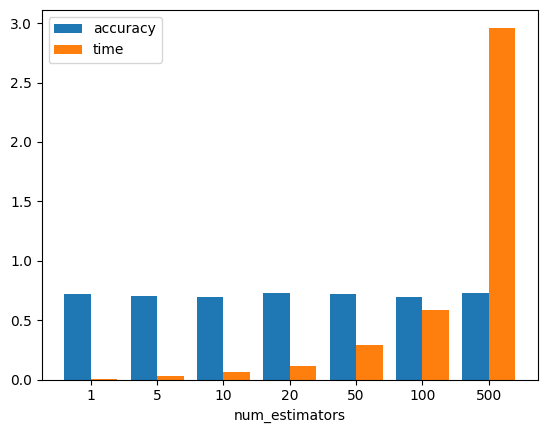

In [76]:
num_estimators = [1, 5, 10, 20, 50, 100, 500]

best_accuracy = 0
best_num_estimators = 0
best_predictions = []
acc = []
times = []
for n in num_estimators:
    start = time.time()
    predictions = AdaBoost(n, 'classification', X_train_class, y_train_class, X_val_class)
    end = time.time()
    times.append(end-start)
    accuracy = accuracy_score(y_val_class, predictions)
    acc.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_num_estimators = n
        best_predictions = predictions

print('Best accuracy: ', best_accuracy)
print('Best num_estimators: ', best_num_estimators)

x = np.arange(len(num_estimators))
plt.bar(x-0.2, acc, width=0.4, label='accuracy')
plt.bar(x+0.2, times, width=0.4, label='time')
plt.xticks(x, num_estimators)
plt.xlabel('num_estimators')
plt.legend()
plt.show()

#### Hyperparameter Tuning

Best r2:  0.5028450949764545
best_num_estimators:  1


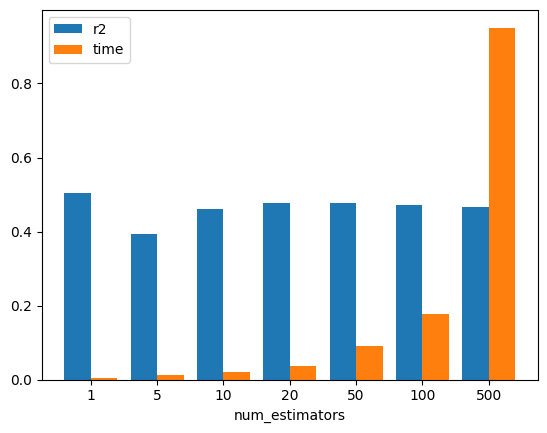

In [100]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(data_x, data_y, test_size=0.2, random_state=42)
X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(X_train_reg, y_train_reg, test_size=0.5, random_state=52)

num_estimators = [1, 5, 10, 20, 50, 100, 500]

best_r2 = 0
best_num_estimators = 0

r2 = []
times = []

for n in num_estimators:
    s = time.time()
    predictions = AdaBoost(n, 'regression', X_train_reg, y_train_reg, X_val_reg)
    e = time.time()
    times.append(e-s)
    r2_s = r2_score(predictions, y_val_reg)
    r2.append(r2_s)
    if r2_s > best_r2:
        best_r2 = r2_s
        best_num_estimators = n
        
print('Best r2: ', best_r2)
print('best_num_estimators: ', best_num_estimators)

x = np.arange(len(num_estimators))
plt.bar(x-0.2, r2, width=0.4, label='r2')
plt.bar(x+0.2, times, width=0.4, label='time')
plt.xticks(x, num_estimators)
plt.xlabel('num_estimators')
plt.legend()
plt.show()       

---

#### Gradient Boosting

In [78]:
def GradientBoosting(num_estimators, type, X_train, y_train, X_val):
    predictions = []
    models = []
    if(type=='regression'):
        # initialize all predictions to mean of y_train
        predictions = np.ones(X_train.shape[0]) * np.mean(y_train)

    else:
        # calculate initial log(odds)
        initial_log_odds = np.log(np.sum(y_train) / (y_train.shape[0] - np.sum(y_train)))
        # initialize all predictions to initial log(odds)
        predictions = np.ones(X_train.shape[0]) * initial_log_odds

    lr = 0.6
    for i in range(num_estimators):
        residual = y_train - predictions

        if(type == 'classification'):
            tree = DecisionTreeRegressor()
        else:
            tree = DecisionTreeRegressor()

        tree.fit(X_train, residual)

        predictions += lr * tree.predict(X_train)
        models.append(tree)

    # predict on validation data
    if(type=='regression'):
        # initialize all predictions to mean of y_train
        predictions = np.ones(X_val.shape[0]) * np.mean(y_train)

    else:
        # calculate initial log(odds)
        initial_log_odds = np.log(np.sum(y_train) / (y_train.shape[0] - np.sum(y_train)))
        # initialize all predictions to initial log(odds)
        predictions = np.ones(X_val.shape[0]) * initial_log_odds
    for i in range(len(models)):
        predictions += lr * models[i].predict(X_val)

    if(type == 'classification'):
        predictions = np.where(predictions > 0.5, 1, 0)

    return predictions

#### Hyperparameter Tuning

Best accuracy:  0.7280701754385965
Best num_estimators:  1


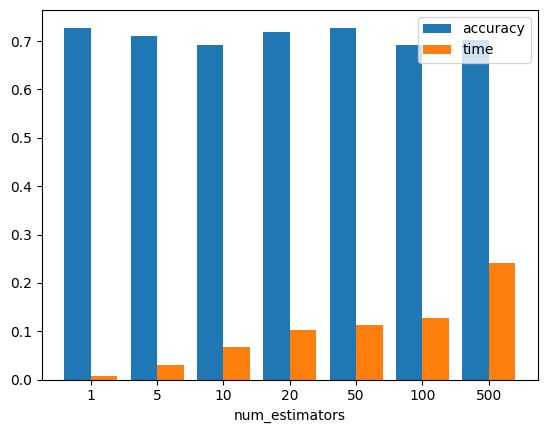

In [79]:
num_estimators = [1, 5, 10, 20, 50, 100, 500]

best_accuracy = 0
best_num_estimators = 0
acc = []
times = []

for n in num_estimators:
    start = time.time()
    predictions = GradientBoosting(n, 'classification', X_train_class, y_train_class, X_val_class)
    end = time.time()
    times.append(end-start)
    accuracy = accuracy_score(y_val_class, predictions)
    acc.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_num_estimators = n

print('Best accuracy: ', best_accuracy)
print('Best num_estimators: ', best_num_estimators)

x = np.arange(len(num_estimators))
plt.bar(x-0.2, acc, width=0.4, label='accuracy')
plt.bar(x+0.2, times, width=0.4, label='time')
plt.xticks(x, num_estimators)
plt.xlabel('num_estimators')
plt.legend()
plt.show()

#### Hyperparameter Tuning

Best r2:  0.5327774134020382
Best num_estimators:  100


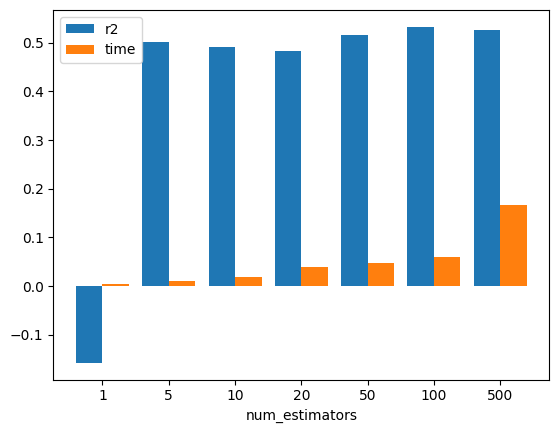

In [101]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(data_x, data_y, test_size=0.2, random_state=42)
X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(X_train_reg, y_train_reg, test_size=0.5, random_state=52)

num_estimators = [1, 5, 10, 20, 50, 100, 500]

best_r2 = 0
best_num_estimators = 0
r2 = []
times = []

for num_estimator in num_estimators:
    start = time.time()
    predictions = GradientBoosting(num_estimator, 'regression', X_train_reg, y_train_reg, X_val_reg)
    end = time.time()
    times.append(end-start)
    r2_s = r2_score(predictions, y_val_reg)
    r2.append(r2_s)
    if r2_s > best_r2:
        best_r2 = r2_s
        best_num_estimators = num_estimator

print('Best r2: ', best_r2)
print('Best num_estimators: ', best_num_estimators)

x = np.arange(len(num_estimators))
plt.bar(x-0.2, r2, width=0.4, label='r2')
plt.bar(x+0.2, times, width=0.4, label='time')
plt.xticks(x, num_estimators)
plt.xlabel('num_estimators')
plt.legend()
plt.show()

---

#### Random Forests vs Boosted Tress
- When it comes to classification tasks, random forests outshine boosted trees due to their lower susceptibility to overfitting.
- However, for regression tasks, both models exhibit comparable performance.

In [81]:
# Random Forest
predictions = RandomForest(100, 1, 1, True, X_train_class, y_train_class, X_val_class, y_val_class, 'classification')
misclassified_rf = np.where(predictions != y_val_class)[0]
print('Number of misclassified samples in random forest: ', len(misclassified_rf))
print('Misclassified samples: ', misclassified_rf)

# AdaBoost
predictions = AdaBoost(100, 'classification', X_train_class, y_train_class, X_val_class)
misclassified_ada = np.where(predictions != y_val_class)[0]
print('Number of misclassified samples in AdaBoost: ', len(misclassified_ada))
print('Misclassified samples: ', misclassified_ada)

# Gradient Boosting
predictions = GradientBoosting(100, 'classification', X_train_class, y_train_class, X_val_class)
misclassified_gb = np.where(predictions != y_val_class)[0]
print('Number of misclassified samples in Gradient Boosting: ', len(misclassified_gb))
print('Misclassified samples: ', misclassified_gb)

Number of misclassified samples in random forest:  26
Misclassified samples:  [ 16  18  22  23  35  41  55  58  65  69  73  80  81  86  88  91  93  94
  97  98  99 101 103 109 110 113]
Number of misclassified samples in AdaBoost:  34
Misclassified samples:  [  0   3  11  16  18  22  26  35  38  40  41  46  47  51  55  58  59  65
  69  74  76  80  81  85  88  91  92  94  96  97  98 101 103 110]
Number of misclassified samples in Gradient Boosting:  36
Misclassified samples:  [  0   3  11  16  18  22  26  28  35  38  40  41  46  47  51  55  58  59
  61  65  69  74  76  80  81  85  88  91  92  94  96  97  98 101 103 110]


In [82]:
common_mistakes = np.intersect1d(misclassified_rf, misclassified_ada)
common_mistakes = np.intersect1d(common_mistakes, misclassified_gb)

print('Number of common misclassified samples: ', len(common_mistakes))
print('Common misclassified samples: ', common_mistakes)

Number of common misclassified samples:  19
Common misclassified samples:  [ 16  18  22  35  41  55  58  65  69  80  81  88  91  94  97  98 101 103
 110]


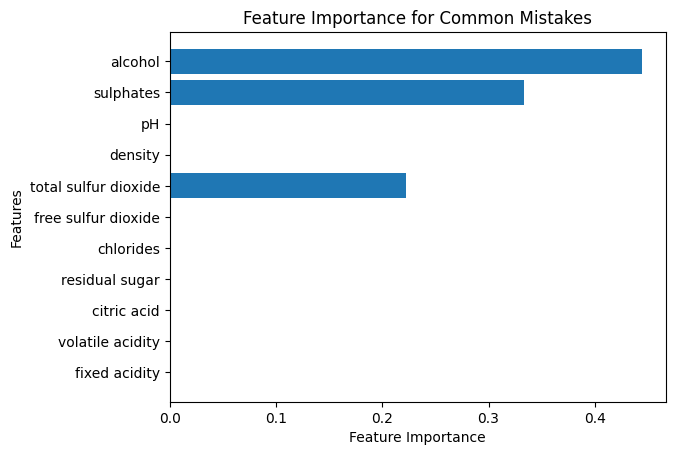

In [85]:
X_train, X_val, y_train, y_val = train_test_split(X_val_class[common_mistakes], y_val_class[common_mistakes], test_size=0.2, random_state=42)

# Create and train a Random Forest model
feature_names = data.columns[:-2]

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
feature_importance = model.feature_importances_
plt.barh(feature_names, feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance for Common Mistakes')
plt.show()

On training a Decision tree on the common mistakes made by the three models, it shows that the feature importances of alcohol and sulphates are high in these mistakes. That is the models are not being able to classify the quality of wine based on alcohol and sulphates. This is can be due to the fact the alcohol and sulphate features are not linearly separable and the decision trees are not able to capture this non-linearity.